In [3]:
# %run -i ../../GitHub/Useful_ML_Notebooks/libs.py
import pandas as pd
import numpy as np
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from business_models import hahn, greenplum 

def get_zaic(df,*args):
    ti()
    if not(isinstance(df,pd.DataFrame) or isinstance(df,pd.Series)):
        print('Не могу вернуть размер для объекта с типом',type(df))
    elif isinstance(df,pd.Series) or isinstance(df,pd.DataFrame) and df.shape[1] == 1:
        print(round(df.memory_usage(deep=True)/1024**2,2),'Mb')
    else:
        print(round(df.memory_usage(deep=True).sum()/1024**2,2),'Mb')
    print(df.shape)
    
def ti():
    print(dt.now().replace(microsecond=0))
    

%matplotlib inline

In [462]:
cols = ['hex_gid',
        'pop_v3', 'coef_v3', 
       'jews_share', 
       'penetration', 'is_target_area', 'is_service_bad', 'christian',
       'jewish', 'muslim', 'unknown', 'is_not_habitated', 'coffee',
       'kindergarten', 'parks',  'university', 
       'resid_buildings_share', 'mean height', 'resid_buildings_count', 'hist',
       'urban-business-center', 'urban-gov', 'urban-industrial',
       'urban-leisure', 'urban-med-hospital', 'urban-public', 'urban-shopping',
        'cluster_6',
       'cluster_3',  'cluster_1.0', 'cluster_2.0',
       'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 
       'soc-econom index',  'distance_straight',
       'FAR', 'buildings_area', 'sq', 'density', 'age_months',
       'cluster_6.0', 'cluster_7.0', 'cluster_8.0','sample'
       ]
corr_cols = ['odds', 'log_odds', 'predict_rf', 'pop_v3', 'orders', 'avg_check', 'avg_cte', 'coef_v3',
       'others_share', 'is_target_area','hex_gid',
       'is_service_bad', 'count','y_predict' ,'FAR', 'resid_buildings_count',
             'english name']
df = pd.read_csv('./data_isr.csv')
df = df[cols]
get_zaic(df)
df.head(3)

2022-07-13 16:24:57
0.65 Mb
(1448, 45)


,hex_gid,pop_v3,coef_v3,jews_share,penetration,is_target_area,is_service_bad,christian,jewish,muslim,...,distance_straight,FAR,buildings_area,sq,density,age_months,cluster_6.0,cluster_7.0,cluster_8.0,sample
0,892db0cd0c7ffff,1792.720570,2.317997,0.833646,0.012830,True,0.0,0.0,1.0,0.0,...,578.547661,0.583076,17038.519577,70150.265887,0.025555,13,0,0,0,train
1,892db0cd083ffff,3020.350410,2.317997,0.785028,0.021521,True,0.0,0.0,2.0,0.0,...,454.061590,0.820112,11619.445412,98668.600247,0.030611,13,0,1,0,test
2,892db0c892fffff,490.640261,0.787184,0.899304,0.008153,False,0.0,1.0,1.0,1.0,...,1826.279596,0.034901,4195.410288,9488.240712,0.015422,13,0,0,0,train


In [463]:
# prof.ProfileReport(df)

In [464]:
target = 'penetration'
model_cols = [x for x in df.columns if x not in corr_cols + [target]]

df_model = df[model_cols + [target,'hex_gid']].copy()
df_model = df_model[~df_model[target].isna()]
get_zaic(df_model)
df_model.head(3)

2022-07-13 16:24:59
0.6 Mb
(1448, 39)


,jews_share,christian,jewish,muslim,unknown,is_not_habitated,coffee,kindergarten,parks,university,...,buildings_area,sq,density,age_months,cluster_6.0,cluster_7.0,cluster_8.0,sample,penetration,hex_gid
0,0.833646,0.0,1.0,0.0,0.0,0,1.0,3.0,51.0,0.0,...,17038.519577,70150.265887,0.025555,13,0,0,0,train,0.012830,892db0cd0c7ffff
1,0.785028,0.0,2.0,0.0,0.0,1,2.0,3.0,64.0,0.0,...,11619.445412,98668.600247,0.030611,13,0,1,0,test,0.021521,892db0cd083ffff
2,0.899304,1.0,1.0,1.0,1.0,0,3.0,4.0,16.0,0.0,...,4195.410288,9488.240712,0.015422,13,0,0,0,train,0.008153,892db0c892fffff


In [467]:
df_types = pd.DataFrame(df_model.dtypes)
display(df_types[df_types[0] == object])
list_obj = [x for x in list(df_types[df_types[0] == object].index) if x != 'sample']

print()
print('nunique():')
print()
for elem in list_obj:
    print(elem, df_model[elem].nunique())
    
print('df shape = ', df_model.shape)
# df_model = pd.get_dummies(df_model, columns=list_obj)
print('df shape = ', df_model.shape)

# lgb работает с категориальными хорошо, но потом сложнее отбирать признаки
# for elem in list_obj:
#     df_model[elem] = df_model[elem].astype('category')

,0
sample,object
hex_gid,object



nunique():

hex_gid 1448
df shape =  (1448, 39)
df shape =  (1448, 39)


In [471]:
model_cols = [x for x in df_model.columns if x != target and x != 'sample' and x!='hex_gid']
seed_val = 7575

encode_dict = {}
k = 0
for elem in model_cols:
    new_elem = ''
    for sym in elem:
        if str.isalpha(sym) or str.isdigit(sym) or sym == '_':
            new_elem += sym
        elif str.isspace(sym) or sym == '-':
            new_elem += '_'
    encode_dict[elem] = new_elem

model_cols = list(encode_dict.values())
df_model.rename(columns=encode_dict, inplace=True)

X_train = df_model[(df_model['sample'] == 'train')][model_cols]
y_train = df_model[(df_model['sample'] == 'train')][target]
X_test = df_model[(df_model['sample'] == 'test')][model_cols]
y_test = df_model[(df_model['sample'] == 'test')][target]

In [472]:
df.rename(columns=encode_dict, inplace=True)

In [473]:
import lightgbm as lgb

In [474]:


def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

METRIC = 'rmse' # rmsle 'mae'

In [475]:
%%time
grid2 ={'n_estimators':np.arange(20,40,3),
         'max_depth': [ 2,3]}
lgbc = lgb.LGBMRegressor(n_jobs=-1, 
                          silent = True, 
                          random_state = seed_val,
                          importance_type='gain')
fit_params = {
    'eval_metric': METRIC, 
    'eval_set':[(X_train, y_train), (X_test, y_test)], 
    'early_stopping_rounds' : 50
}
# rscv = RandomizedSearchCV(lgbc, grid2, cv=3, random_state=seed_val, verbose=1,)
rscv = GridSearchCV(lgbc, grid2, cv=3, n_jobs=6)
search = rscv.fit(X_train, y_train, **fit_params)

[1]	valid_0's rmse: 0.0488608	valid_0's l2: 0.00238738	valid_1's rmse: 0.0416908	valid_1's l2: 0.00173812
[2]	valid_0's rmse: 0.0481316	valid_0's l2: 0.00231665	valid_1's rmse: 0.0409437	valid_1's l2: 0.00167639
[3]	valid_0's rmse: 0.0477089	valid_0's l2: 0.00227614	valid_1's rmse: 0.0405624	valid_1's l2: 0.00164531
[4]	valid_0's rmse: 0.0471962	valid_0's l2: 0.00222748	valid_1's rmse: 0.0400665	valid_1's l2: 0.00160533
[5]	valid_0's rmse: 0.0467826	valid_0's l2: 0.00218861	valid_1's rmse: 0.0397763	valid_1's l2: 0.00158215
[6]	valid_0's rmse: 0.0463201	valid_0's l2: 0.00214555	valid_1's rmse: 0.0393654	valid_1's l2: 0.00154964
[7]	valid_0's rmse: 0.0458688	valid_0's l2: 0.00210395	valid_1's rmse: 0.038901	valid_1's l2: 0.00151329
[8]	valid_0's rmse: 0.0455006	valid_0's l2: 0.00207031	valid_1's rmse: 0.0386416	valid_1's l2: 0.00149317
[9]	valid_0's rmse: 0.0451584	valid_0's l2: 0.00203928	valid_1's rmse: 0.0382545	valid_1's l2: 0.00146341
[10]	valid_0's rmse: 0.0448144	valid_0's l2: 0.

[10]	training's rmse: 0.041532	training's l2: 0.00172491	valid_1's rmse: 0.0358562	valid_1's l2: 0.00128567
[11]	training's rmse: 0.0410985	training's l2: 0.00168909	valid_1's rmse: 0.0356145	valid_1's l2: 0.00126839
[12]	training's rmse: 0.0405441	training's l2: 0.00164382	valid_1's rmse: 0.0353921	valid_1's l2: 0.0012526
[13]	training's rmse: 0.0401407	training's l2: 0.00161127	valid_1's rmse: 0.035054	valid_1's l2: 0.00122878
[14]	training's rmse: 0.0396588	training's l2: 0.00157282	valid_1's rmse: 0.0346973	valid_1's l2: 0.0012039
[15]	training's rmse: 0.0393135	training's l2: 0.00154555	valid_1's rmse: 0.0344809	valid_1's l2: 0.00118893
[16]	training's rmse: 0.0389392	training's l2: 0.00151626	valid_1's rmse: 0.034393	valid_1's l2: 0.00118288
[17]	training's rmse: 0.0385384	training's l2: 0.00148521	valid_1's rmse: 0.0341835	valid_1's l2: 0.00116851
[18]	training's rmse: 0.038268	training's l2: 0.00146444	valid_1's rmse: 0.0340864	valid_1's l2: 0.00116188
[19]	training's rmse: 0.0

/home/intra26/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/intra26/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/intra26/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed i

In [196]:
from sklearn.metrics import r2_score

In [476]:
print(search.best_params_)

model = lgb.LGBMRegressor(**search.best_params_)
model.fit(X_train,y_train)
y_train_hat = model.predict(X_train)
max_gini_train = r2_score(y_train, y_train_hat)
print('r2_score Train: ', np.round(max_gini_train, 3))

y_test_hat = model.predict(X_test)
print('r2_score Test: ', np.round(r2_score(y_test, y_test_hat), 3))

{'max_depth': 3, 'n_estimators': 38}
r2_score Train:  0.531
r2_score Test:  0.386


In [477]:
y_test_hat = model.predict(df_model[model_cols])
print('r2_score Test: ', np.round(r2_score(df_model[target], y_test_hat), 3))

r2_score Test:  0.476


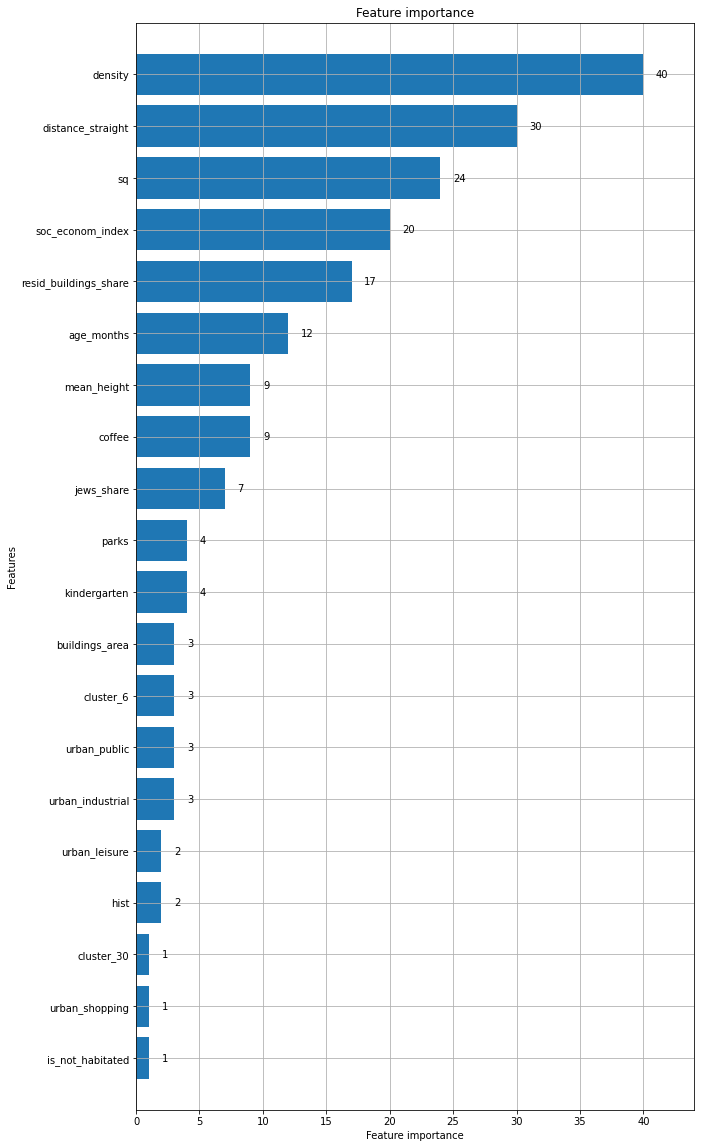

In [478]:
fig, ax = plt.subplots(1,1,figsize=(10, 20))
ax.set_xlabel('Значимость фактора')
ax.set_ylabel('Имя фактора')
ax.set_title('')
_ = lgb.plot_importance(model, height=0.8, ax=ax)

In [479]:
tuple_feat = list()
imp = model.feature_importances_
cols = X_train.columns
for i in range(len(X_train.columns)):
    tuple_feat.append((imp[i], cols[i]))
tuple_feat.sort(reverse=True)

top_feat = list()
for elem in tuple_feat[:20]:
    top_feat.append(elem[1])
top_feat

['density',
 'distance_straight',
 'sq',
 'soc_econom_index',
 'resid_buildings_share',
 'age_months',
 'mean_height',
 'coffee',
 'jews_share',
 'parks',
 'kindergarten',
 'urban_public',
 'urban_industrial',
 'cluster_6',
 'buildings_area',
 'urban_leisure',
 'hist',
 'urban_shopping',
 'is_not_habitated',
 'cluster_30']

<AxesSubplot:>

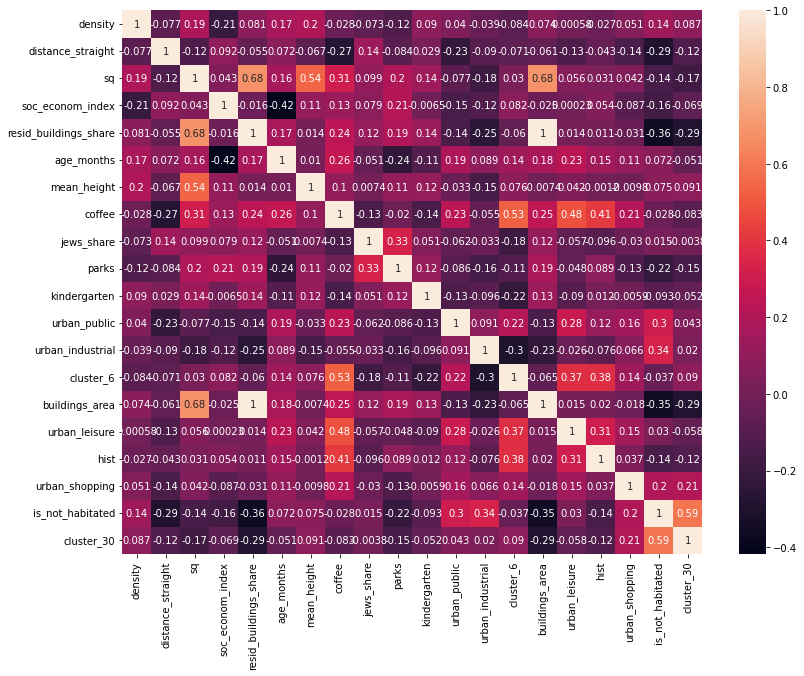

In [480]:
import seaborn as sns
plt.figure(figsize=(13,10))
sns.heatmap(df_model[top_feat].corr(), annot=True)

In [481]:
model_cols = top_feat

X_train = df_model[(df_model['sample'] == 'train')][model_cols]
y_train = df_model[(df_model['sample'] == 'train')][target]
X_test = df_model[(df_model['sample'] == 'test')][model_cols]
y_test = df_model[(df_model['sample'] == 'test')][target]

In [482]:
%%time
grid2 = {'n_estimators':np.arange(5,35,5),
         'max_depth': [2, 4]}
lgbc = lgb.LGBMRegressor(n_jobs=-1, 
                          silent = True, 
                          random_state = seed_val,
                          importance_type='gain')
fit_params = {
    'eval_metric': METRIC, 
    'eval_set':[(X_train, y_train), (X_test, y_test)], 
    'early_stopping_rounds' : 150
}
# rscv = RandomizedSearchCV(lgbc, grid2, cv=3, random_state=seed_val, verbose=1,)
rscv = GridSearchCV(lgbc, grid2, cv=3, n_jobs=6)
search = rscv.fit(X_train, y_train, **fit_params)


[1]	valid_0's rmse: 0.04867	valid_0's l2: 0.00236877	valid_1's rmse: 0.0415434	valid_1's l2: 0.00172585
[2]	valid_0's rmse: 0.0477685	valid_0's l2: 0.00228183	valid_1's rmse: 0.0406023	valid_1's l2: 0.00164855
[3]	valid_0's rmse: 0.0468981	valid_0's l2: 0.00219944	valid_1's rmse: 0.0398151	valid_1's l2: 0.00158524
[4]	valid_0's rmse: 0.0461823	valid_0's l2: 0.00213281	valid_1's rmse: 0.0391243	valid_1's l2: 0.00153071
[5]	valid_0's rmse: 0.0456483	valid_0's l2: 0.00208377	valid_1's rmse: 0.038774	valid_1's l2: 0.00150342
[6]	valid_0's rmse: 0.0451286	valid_0's l2: 0.00203659	valid_1's rmse: 0.0384563	valid_1's l2: 0.00147889
[7]	valid_0's rmse: 0.044499	valid_0's l2: 0.00198016	valid_1's rmse: 0.0381587	valid_1's l2: 0.00145608
[8]	valid_0's rmse: 0.0440153	valid_0's l2: 0.00193735	valid_1's rmse: 0.037894	valid_1's l2: 0.00143596
[9]	valid_0's rmse: 0.0438446	valid_0's l2: 0.00192235	valid_1's rmse: 0.0376885	valid_1's l2: 0.00142042
[10]	valid_0's rmse: 0.0433402	valid_0's l2: 0.001

/home/intra26/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/intra26/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [483]:
print(search.best_params_)

model = lgb.LGBMRegressor(**search.best_params_)
model.fit(df_model[model_cols],df_model[target])
y_train_hat = model.predict(X_train)
max_gini_train = r2_score(y_train, y_train_hat)
print('r2_score Train: ', np.round(max_gini_train, 3))

y_test_hat = model.predict(X_test)
print('r2_score Test: ', np.round(r2_score(y_test, y_test_hat), 3))

{'max_depth': 4, 'n_estimators': 30}
r2_score Train:  0.525
r2_score Test:  0.547


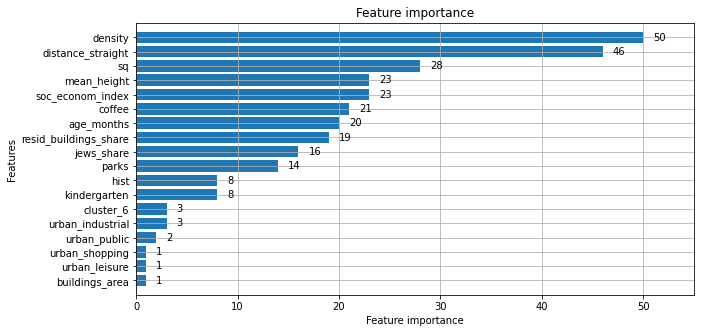

In [484]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_xlabel('Значимость фактора')
ax.set_ylabel('Имя фактора')
ax.set_title('')
_ = lgb.plot_importance(model, height=0.8, ax=ax)

In [485]:
model_cols

['density',
 'distance_straight',
 'sq',
 'soc_econom_index',
 'resid_buildings_share',
 'age_months',
 'mean_height',
 'coffee',
 'jews_share',
 'parks',
 'kindergarten',
 'urban_public',
 'urban_industrial',
 'cluster_6',
 'buildings_area',
 'urban_leisure',
 'hist',
 'urban_shopping',
 'is_not_habitated',
 'cluster_30']

In [488]:
tuple_feat = list()
imp = model.feature_importances_
cols = X_train.columns
for i in range(len(X_train.columns)):
    tuple_feat.append((imp[i], cols[i]))
tuple_feat.sort(reverse=True)

top_feat = list()
for elem in tuple_feat[:15]:
    top_feat.append(elem[1])
top_feat

['density',
 'distance_straight',
 'sq',
 'soc_econom_index',
 'mean_height',
 'coffee',
 'age_months',
 'resid_buildings_share',
 'jews_share',
 'parks',
 'kindergarten',
 'hist',
 'urban_industrial',
 'cluster_6',
 'urban_public']

In [489]:
model_cols = top_feat

In [435]:
model_cols=[ i for i in model_cols if 'hex_gid' not in i]

In [914]:
model_cols

['density',
 'distance_straight',
 'sq',
 'soc_econom_index',
 'mean_height',
 'coffee',
 'age_months',
 'resid_buildings_share',
 'jews_share',
 'parks',
 'kindergarten',
 'hist',
 'urban_industrial',
 'cluster_6',
 'urban_public']

In [490]:
model.fit(df_model[model_cols],df_model[target])
y_train_hat = model.predict(X_train[model_cols])
max_gini_train = r2_score(y_train, y_train_hat)
print('r2_score Train: ', np.round(max_gini_train, 3))

y_test_hat = model.predict(X_test[model_cols])
print('r2_score Test: ', np.round(r2_score(y_test, y_test_hat), 3))

r2_score Train:  0.523
r2_score Test:  0.544


In [240]:
np.mean(y_test), np.mean(y_test_hat)

(0.04966052982791973, 0.047556764242422916)

In [491]:
df_model['y_predict'] = model.predict(df_model[model_cols])

(array([608., 418., 174.,  95.,  58.,  32.,  23.,  10.,   9.,  21.]),
 array([1.62126832e-04, 2.55008156e-02, 5.08395045e-02, 7.61781933e-02,
        1.01516882e-01, 1.26855571e-01, 1.52194260e-01, 1.77532949e-01,
        2.02871637e-01, 2.28210326e-01, 2.53549015e-01]),
 <BarContainer object of 10 artists>)

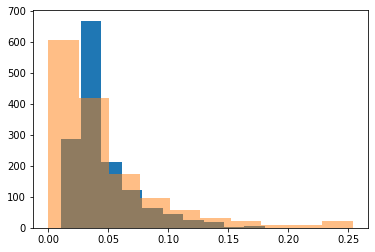

In [492]:
plt.hist(df_model['y_predict'])
plt.hist(df_model[target], alpha=0.5)

In [493]:
df1= df.join(df_model[['y_predict']])

In [494]:
df.columns

Index(['hex_gid', 'pop_v3', 'coef_v3', 'jews_share', 'penetration',
       'is_target_area', 'is_service_bad', 'christian', 'jewish', 'muslim',
       'unknown', 'is_not_habitated', 'coffee', 'kindergarten', 'parks',
       'university', 'resid_buildings_share', 'mean_height',
       'resid_buildings_count', 'hist', 'urban_business_center', 'urban_gov',
       'urban_industrial', 'urban_leisure', 'urban_med_hospital',
       'urban_public', 'urban_shopping', 'cluster_6', 'cluster_3',
       'cluster_10', 'cluster_20', 'cluster_30', 'cluster_40', 'cluster_50',
       'soc_econom_index', 'distance_straight', 'FAR', 'buildings_area', 'sq',
       'density', 'age_months', 'cluster_60', 'cluster_70', 'cluster_80',
       'sample'],
      dtype='object')

In [179]:
# max_gini_train = r2_score(model.predict(df1[model_cols]),df1['y_predict'])
# print('r2_score Train: ', np.round(max_gini_train, 3))


r2_score Train:  1.0


In [495]:
df1.to_csv('data_with_predict.csv')

### Часть 2. Считаем прогноз для всех гексов в Израиле

In [5]:
full_dataset = pd.read_csv('full_dataset_isr.csv')

In [6]:
full_dataset.columns

Index(['hex_gid', 'pop_v3', 'orders', 'penetration', 'place_id',
       'english name', 'arab_share', 'soc_econom_index', 'mean_height',
       'coffee', 'resid_buildings_share', 'jews_share', 'parks',
       'kindergarten', 'hist', 'cluster_6', 'hex_area', 'FAR',
       'buildings_area', 'sq', 'density', 'age_months', 'distance_straight',
       'const', 'urban-business-center', 'urban-edu', 'urban-gov',
       'urban-industrial', 'urban-leisure', 'urban-med-hospital',
       'urban-public', 'urban-religion-worship', 'urban-shopping',
       'urban-sport', 'urban-structure', 'urban-transport'],
      dtype='object')

In [534]:
df_model[model_cols]

,density,distance_straight,sq,soc_econom_index,mean_height,coffee,age_months,resid_buildings_share,jews_share,parks,kindergarten,hist,urban_industrial,cluster_6,urban_public
0,0.025555,578.547661,70150.265887,11.0,4.333333,1.0,13,0.141621,0.833646,51.0,3.0,1.0,0.0,2,0.0
1,0.030611,454.061590,98668.600247,10.0,7.703704,2.0,13,0.096578,0.785028,64.0,3.0,2.0,0.0,3,10.0
2,0.015422,1826.279596,9488.240712,11.0,0.000000,3.0,13,0.000000,0.899304,16.0,4.0,2.0,0.0,4,4.0
3,0.020447,1541.773567,30919.309872,13.0,1.064516,0.0,13,0.219277,0.909755,12.0,4.0,0.0,1.0,3,0.0
4,0.018894,1666.585647,164379.465069,13.0,4.097561,5.0,13,0.321742,0.916992,68.0,12.0,2.0,0.0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,0.028106,2186.777392,186085.652418,12.0,6.346154,1.0,19,0.200360,0.939451,57.0,9.0,2.0,0.0,2,0.0
1444,0.017404,3117.154166,164086.558985,14.0,4.937500,1.0,19,0.246059,0.932371,49.0,8.0,0.0,0.0,2,0.0
1445,0.015784,2788.252619,80418.414017,10.0,2.666667,2.0,19,0.239213,0.934011,51.0,9.0,1.0,0.0,2,0.0
1446,0.015422,1309.429890,9488.240712,11.0,0.000000,10.0,19,0.000000,0.899304,37.0,0.0,6.0,3.0,3,5.0


In [911]:
full_dataset = full_dataset.merge(df_model[['hex_gid','y_predict']], on='hex_gid', how='left')

In [907]:
full_dataset.columns

Index(['Unnamed: 0', 'hex_gid', 'pop_v3', 'orders', 'penetration', 'place_id',
       'english name', 'arab_share', 'soc_econom_index', 'mean_height',
       'coffee', 'resid_buildings_share', 'jews_share', 'parks',
       'kindergarten', 'hist', 'urban_industrial', 'cluster_6', 'urban_public',
       'hex_area', 'FAR', 'buildings_area', 'sq', 'density', 'age_months',
       'distance_straight', 'const', 'urban-business-center', 'urban-edu',
       'urban-gov', 'urban-industrial', 'urban-leisure', 'urban-med-hospital',
       'urban-public', 'urban-religion-worship', 'urban-shopping',
       'urban-sport', 'urban-structure', 'urban-transport'],
      dtype='object')

In [920]:
full_dataset.rename(columns={'urban-industrial':'urban_industrial','urban-public':'urban_public'}, inplace=True)

In [921]:
full_dataset.loc[pd.isnull(full_dataset['y_predict']),'y_predict']= model.predict(full_dataset.loc[pd.isnull(full_dataset['y_predict']),model_cols])

In [922]:
full_dataset['place_id'] = full_dataset['place_id'].fillna(0).astype(int).astype(str)

In [309]:
gdf_isr_zones = gpd.read_file('Тель-Авив_zones_2022-07-11.geojson')

In [310]:
import geopandas as gpd

In [952]:
gdf_isr_zones.groupby(['external_id','title']).size()

external_id  title                          
266222       Ramat Gan, Zeev Jabutinsky, 124    2
298248       Tel Aviv, HaShlosha, 11            2
298283       Tel Aviv, HaRabbi Mibachrach, 4    2
396338       Holon, Ha'Lahav, 15                2
396798       Tel Aviv, Ben-Yehuda, 32           2
403349       Rishon LeZion, Sakharov, 22        2
403364       Bat Yam, Ehud Kinnamon, 37         2
435417       Ramat Gan, Zeev Jabotinsky, 33     2
435682       Modin, Dam HaMacbim, 36            1
435692       Bat Yam, Sderot HaAtsmaut, 64      2
435697       Haifa, Sderot Moriah, 11           1
437047       Petah tikva, Bar Kochva, 75        2
461221       Rishon LeZion, Moshe Beker, 14     2
484191       Ness Ziona, Bialik, 1              2
484221       Ra'anana, HaHaroshet, 14           2
484226       Tel Aviv, Aharon Becker, 8         2
538973       Petah Tikva, Bareket, 9            2
575777       Kfar saba, Hagavish 5              1
592601       Ramat hasharon, Sokolov 111        2
dtype

In [923]:
full_dataset = full_dataset.merge(gdf_isr_zones[gdf_isr_zones.delivery_type=='foot'], left_on='place_id', right_on='external_id', how='left')

In [950]:
df.corr()['penetration'][top_feat]

density                 -0.243497
distance_straight       -0.223677
sq                      -0.095584
soc_econom_index        -0.055543
mean_height             -0.073633
coffee                   0.231898
age_months               0.209148
resid_buildings_share   -0.051244
jews_share              -0.139759
parks                   -0.034385
kindergarten            -0.078529
hist                     0.091158
urban_industrial         0.045588
cluster_6                0.152213
urban_public             0.167383
Name: penetration, dtype: float64

In [924]:
full_dataset['frq']=3
full_dataset['penetration_users'] = full_dataset['penetration']/full_dataset['frq']
full_dataset['predict_penetration_users'] = full_dataset['y_predict']/full_dataset['frq']

In [925]:
full_dataset['predict_orders'] = full_dataset['y_predict']*full_dataset['pop_v3']

In [926]:
full_dataset.groupby(['title','hex_gid']).size()

title                       hex_gid        
Bat Yam, Ehud Kinnamon, 37  892db0c892fffff    1
                            892db0cd003ffff    1
                            892db0cd007ffff    1
                            892db0cd013ffff    1
                            892db0cd017ffff    1
                                              ..
Tel Aviv, HaShlosha, 11     892db0cddcbffff    1
                            892db0cddcfffff    1
                            892db0cddd3ffff    1
                            892db0cddd7ffff    1
                            892db0cdddbffff    1
Length: 1510, dtype: int64

In [927]:
full_dataset[full_dataset['place_id']!='0'].groupby('english name')['penetration_users'].mean()

english name
-1                         0.037373
AZOR                       0.011172
BAT YAM                    0.013077
BE'ER YA'AQOV              0.011767
BENE BERAQ                 0.007035
GAN HAYYIM                 0.002780
GANNE TIQWA                0.006326
GAT RIMMON                 0.005271
GELIL YAM                  0.019449
GIV'AT SHEMU'EL            0.006404
GIV'ATAYIM                 0.017824
HAIFA                      0.014527
HERZLIYYA                  0.005944
HOLON                      0.010377
KEFAR MALAL                0.001056
KEFAR SAVA                 0.003602
MA'AS                      0.015874
MIQWE YISRA'EL             0.019913
MODI'IN-MAKKABBIM-RE'UT    0.008096
NES ZIYYONA                0.013793
NEWE YAMIN                 0.006122
PETAH TIQWA                0.013298
QIRYAT ONO                 0.004485
RA'ANNANA                  0.008466
RAMAT GAN                  0.018911
RAMAT HASHARON             0.009277
RISHON LEZIYYON            0.013322
TEL AVIV - YAFO

In [ ]:
# max penetration - 5%, current - 1.5%. calculate coefficient to make 5 from 1.5

In [865]:
df[df['age_months']>10&(df['age_months']<14)]['penetration'].mean()/3

0.015114627811837254

In [512]:
'0.015114627811837254 -> 0.05'

'0.020591 -> 0.021015'

In [723]:
0.05/0.015114627811837254  # coefficient

3.3080536697596834

In [928]:
full_dataset['penetration_target'] = full_dataset['predict_penetration_users']*3.3

In [929]:
full_dataset.groupby('title')['penetration_users','predict_penetration_users','frq','penetration_target'].mean().join(full_dataset.groupby('title')['pop_v3','orders','predict_orders'].sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,penetration_users,predict_penetration_users,frq,penetration_target,pop_v3,orders,predict_orders
title,,,,,,,
"Bat Yam, Ehud Kinnamon, 37",0.012413,0.012928,3.0,0.042664,132566.313627,4202.0,4594.425894
"Bat Yam, Sderot HaAtsmaut, 64",0.016600,0.018303,3.0,0.060398,126705.022453,4362.0,5101.365564
"Haifa, Sderot Moriah, 11",0.014527,0.016412,3.0,0.054161,55137.879355,1973.0,2369.868228
"Holon, Ha'Lahav, 15",0.017326,0.013333,3.0,0.043998,100415.302615,3053.0,3437.532957
"Kfar saba, Hagavish 5",0.002475,0.012704,3.0,0.041922,80216.213240,475.0,2692.092667
"Modin, Dam HaMacbim, 36",0.008096,0.011072,3.0,0.036537,96500.936426,2427.0,3194.279996
"Ness Ziona, Bialik, 1",0.013793,0.014821,3.0,0.048910,56167.409713,2015.0,1950.514541
"Petah Tikva, Bareket, 9",0.012880,0.012704,3.0,0.041923,124172.907389,2775.0,3447.829134
"Petah tikva, Bar Kochva, 75",0.013774,0.012507,3.0,0.041272,198952.130308,8084.0,7656.326139


In [930]:
full_dataset.loc[full_dataset.pop_v3<50,'penetration_target']=0.02

In [931]:
full_dataset.loc[full_dataset.arab_share>0.6,'penetration_target' ]=0.0001

In [932]:
full_dataset.groupby('title')['penetration_users','predict_penetration_users','frq','penetration_target'].mean().join(full_dataset.groupby('title')['pop_v3','orders','predict_orders'].sum()).to_csv('isr_zones_predict_fact.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


(array([3.212e+03, 1.100e+04, 1.826e+03, 9.720e+02, 1.230e+03, 9.580e+02,
        1.740e+02, 1.900e+01, 0.000e+00, 1.000e+00]),
 array([1.00000000e-04, 1.99345035e-02, 3.97690069e-02, 5.96035104e-02,
        7.94380139e-02, 9.92725174e-02, 1.19107021e-01, 1.38941524e-01,
        1.58776028e-01, 1.78610531e-01, 1.98445035e-01]),
 <BarContainer object of 10 artists>)

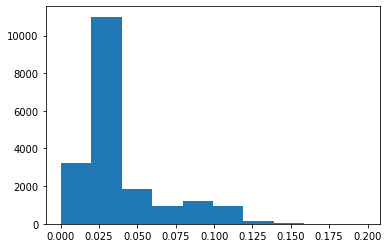

In [728]:
plt.hist(full_dataset['penetration_target'])

In [933]:
full_dataset['pop_v3'] = full_dataset['pop_v3'].replace(0.01,0)
full_dataset.groupby('english name')['pop_v3'].sum().sort_values(ascending=False)*0.90


english name
JERUSALEM            992022.805819
TEL AVIV - YAFO      521945.354542
HAIFA                262340.680922
RISHON LEZIYYON      252381.517536
PETAH TIQWA          250006.186677
                         ...      
QEDMA                     0.000000
HAR ADAR                  0.000000
SAWA'ID(HAMRIYYE)         0.000000
SENIR                     0.000000
NURIT                     0.000000
Name: pop_v3, Length: 962, dtype: float64

In [871]:
# full_dataset['pop_v3']=full_dataset['pop_v3']*0.90

In [729]:
full_dataset.groupby('english name')['pop_v3'].sum().sort_values(ascending=False)

english name
JERUSALEM            992022.805819
TEL AVIV - YAFO      521945.354542
HAIFA                262340.680922
RISHON LEZIYYON      252381.517536
PETAH TIQWA          250006.186677
                         ...      
QEDMA                     0.000000
HAR ADAR                  0.000000
SAWA'ID(HAMRIYYE)         0.000000
SENIR                     0.000000
NURIT                     0.000000
Name: pop_v3, Length: 962, dtype: float64

In [934]:
full_dataset['predict_orders'] = full_dataset['y_predict']*full_dataset['pop_v3']
full_dataset['orders_target']= full_dataset['penetration_target']*full_dataset['pop_v3']*full_dataset['frq']

In [731]:
full_dataset.groupby('english name')['pop_v3'].sum().sort_values(ascending=False).to_frame().join(
    full_dataset.groupby('english name')['penetration_target','predict_penetration_users'].mean()
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,pop_v3,penetration_target,predict_penetration_users
english name,,,
JERUSALEM,992022.805819,0.031520,0.011902
TEL AVIV - YAFO,521945.354542,0.069701,0.022848
HAIFA,262340.680922,0.040820,0.013109
RISHON LEZIYYON,252381.517536,0.042423,0.015513
PETAH TIQWA,250006.186677,0.043328,0.016282
...,...,...,...
QEDMA,0.000000,0.020000,0.048145
HAR ADAR,0.000000,0.020000,0.041249
SAWA'ID(HAMRIYYE),0.000000,0.000100,0.048159


In [935]:
full_dataset.groupby('english name')['predict_orders','orders_target','pop_v3'].sum().sort_values(ascending=False, by='orders_target').join(full_dataset.groupby('english name')['predict_penetration_users','penetration_target','frq'].mean()).to_csv('isr_localities_predict_orders_1707.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [7]:
df_local_predict = pd.read_csv('isr_localities_predict_orders_1707.csv')

In [ ]:
greenplum.write(df_local_predict,'')

In [576]:
full_dataset['geometry'].isnull().sum()

17882

In [936]:
full_dataset.describe()

,pop_v3,orders,penetration,arab_share,soc_econom_index,mean_height,coffee,resid_buildings_share,jews_share,parks,...,urban-sport,urban-structure,urban-transport,y_predict,frq,penetration_users,predict_penetration_users,predict_orders,penetration_target,orders_target
count,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000,...,19392.000000,19392.000000,19392.000000,19392.000000,19392.0,19392.000000,19392.000000,19392.000000,19392.000000,19392.000000
mean,485.038671,15.954672,0.003499,0.174842,7.801026,1.424339,1.447298,0.086505,0.793587,17.505827,...,0.044245,0.881601,0.005518,0.075788,3.0,0.001166,0.025263,16.576016,0.035645,46.778484
std,849.642319,27.084093,0.015384,0.354085,3.711420,1.631802,5.227239,0.089298,0.298273,25.411698,...,0.362922,2.544211,0.100129,0.045867,0.0,0.005128,0.015289,31.356006,0.031618,104.946797
min,0.000000,1.000000,0.000100,0.000095,1.000000,0.000000,0.000000,0.000000,0.000046,0.000000,...,0.000000,0.000000,0.000000,0.009309,3.0,0.000033,0.003103,0.000000,0.000100,0.000000
25%,21.506222,12.000000,0.000100,0.001662,6.000000,1.000000,0.000000,0.010832,0.810435,0.000000,...,0.000000,0.000000,0.000000,0.029848,3.0,0.000033,0.009949,2.572833,0.020000,0.094581
50%,132.419019,12.000000,0.000100,0.001662,6.000000,1.012579,0.000000,0.058136,0.907310,7.000000,...,0.000000,0.000000,0.000000,0.070068,3.0,0.000033,0.023356,7.803042,0.022947,17.963437
75%,567.514443,12.000000,0.000100,0.034874,9.000000,1.265674,1.000000,0.139725,0.977175,25.000000,...,0.000000,0.000000,0.000000,0.122556,3.0,0.000033,0.040852,16.982801,0.044604,45.162998
max,11390.203020,629.000000,0.112118,1.000000,20.000000,30.500000,101.000000,0.686548,1.000000,220.000000,...,21.000000,36.000000,3.000000,0.180405,3.0,0.037373,0.060135,921.385432,0.198445,3040.571925


In [578]:
gdf_hex = gpd.read_file('gdf_hex_isr_full_2604.geojson')

In [937]:
gdf_full_dataset = gdf_hex[['hex_gid','geometry']].merge(full_dataset.drop('geometry', axis=1), on='hex_gid',how='left' )

In [876]:
top_feat

['density',
 'distance_straight',
 'sq',
 'soc_econom_index',
 'mean_height',
 'coffee',
 'age_months',
 'resid_buildings_share',
 'jews_share',
 'parks',
 'kindergarten',
 'hist',
 'urban_industrial',
 'cluster_6',
 'urban_public']

In [938]:
gdf_full_dataset.to_file('gdf_full_dataset.geojson',driver='GeoJSON')

DBSCAN - to find areas with high number of predicted orders. This will be support for final lavka zones 

In [878]:
isr_crs='epsg:32636'

In [879]:
gdf_full_dataset_good = gdf_full_dataset[(gdf_full_dataset['orders_target']>5)]

# gdf_full_dataset_good = gdf_hex_isr_full[['hex_gid','geometry']].merge(full_dataset_good, on ='hex_gid')

gdf_full_dataset_good_utm = gdf_full_dataset_good.to_crs(isr_crs)

gdf_full_dataset_good['center_x']=gdf_full_dataset_good_utm.geometry.centroid.x
gdf_full_dataset_good['center_y']=gdf_full_dataset_good_utm.geometry.centroid.y

from sklearn.cluster import DBSCAN

X = gdf_full_dataset_good[['center_x','center_y']]
clustering = DBSCAN(eps=1500, min_samples=40).fit(X)
clustering.labels_

gdf_full_dataset_good['dbscan_num'] = clustering.labels_

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [739]:
gdf_full_dataset_good['dbscan_num'].value_counts()

-1     4406
 1     1622
 8      626
 4      268
 0      237
 7      210
 12     200
 9      180
 13     151
 3      149
 19     134
 6      118
 2      116
 20      85
 26      84
 15      82
 14      82
 24      79
 28      74
 23      70
 11      70
 22      68
 21      68
 17      64
 29      62
 25      61
 37      61
 33      54
 18      52
 32      51
 38      50
 27      49
 30      49
 10      49
 16      47
 34      47
 35      44
 31      43
 39      43
 36      43
 40      41
 5       40
Name: dbscan_num, dtype: int64

In [880]:
gdf_full_dataset_good['dbscan_num'].nunique()-1

41

In [881]:
ind = gdf_full_dataset_good.groupby(['dbscan_num'])['orders_target'].sum()[gdf_full_dataset_good.groupby(['dbscan_num'])['orders_target'].sum()>8000].index

In [882]:
ind = [ i for i in ind if i>=0]

In [742]:
gdf_full_dataset_good.groupby(['dbscan_num','english name'])['orders_target'].sum()[gdf_full_dataset_good.groupby(['dbscan_num','english name'])['orders_target'].sum()>8000]

dbscan_num  english name           
0           BE'ER SHEVA                 23938.371179
1           BAT YAM                     18464.066734
            BENE BERAQ                  16790.391974
            GIV'ATAYIM                  13558.688917
            HERZLIYYA                   10797.447026
            HOLON                       20611.192185
            KEFAR SAVA                  11345.839535
            PETAH TIQWA                 30361.556450
            RAMAT GAN                   21078.972445
            TEL AVIV - YAFO            103278.137708
2           MODI'IN-MAKKABBIM-RE'UT     11714.411147
4           HAIFA                       24103.846269
8           JERUSALEM                   77251.987437
9           REHOVOT                     13773.738801
12          RISHON LEZIYYON             27181.131618
13          ASHQELON                    12997.254367
19          ASHDOD                      18894.132023
26          NETANYA                     13800.101310
37        

In [743]:
gdf_full_dataset_good.groupby(['english name'])['orders_target'].sum().to_frame().sort_values(by='orders_target',ascending=False).head(20)

,orders_target
english name,
TEL AVIV - YAFO,103510.383095
JERUSALEM,84106.326937
PETAH TIQWA,30380.103246
HAIFA,28244.035398
RISHON LEZIYYON,27725.217644
NETANYA,26191.019909
BE'ER SHEVA,24173.728164
RAMAT GAN,21078.972445
HOLON,20891.414191


In [883]:
gdf_full_dataset_good['flg_good']=0
gdf_full_dataset_good.loc[gdf_full_dataset_good['dbscan_num'].isin(ind),'flg_good'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [884]:
gdf_full_dataset_good.loc[gdf_full_dataset_good['flg_good']==1].groupby('english name')['orders_target'].sum()[gdf_full_dataset_good.loc[gdf_full_dataset_good['flg_good']==1].groupby('english name')['orders_target'].sum()>5000]

english name
ASHDOD                      18913.721845
ASHQELON                    13036.077416
BAT YAM                     18464.066734
BE'ER SHEVA                 23960.583539
BENE BERAQ                  16790.391974
GIV'ATAYIM                  13558.688917
HAIFA                       28263.737317
HERZLIYYA                   10809.514647
HOD HASHARON                 5087.061462
HOLON                       20905.967319
JERUSALEM                   77307.928564
KEFAR SAVA                  11345.839535
LOD                          5638.941634
MODI'IN-MAKKABBIM-RE'UT     11726.189112
NES ZIYYONA                  6220.548025
NETANYA                     21994.584751
PETAH TIQWA                 30378.859237
QIRYAT MOTZKIN               5394.637523
RA'ANNANA                    7067.455781
RAMAT GAN                   21078.972445
RAMAT HASHARON               7227.736016
RAMLA                        5337.274074
REHOVOT                     13773.738801
RISHON LEZIYYON             27607.668506
TEL

In [746]:
gdf_full_dataset_good['predict_orders_rank'] = gdf_full_dataset_good.groupby('dbscan_num')['orders_target'].rank(ascending=False)
# gdf_full_dataset_good.loc[gdf_full_dataset_good['best_ord'] ==gdf_full_dataset_good['predict_orders_target'],'']

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [755]:
gdf_full_dataset_good.to_file('isr_gdf_full_dataset_good.geojson', driver='GeoJSON')

In [ ]:
gdf_full_dataset_good

In [603]:
gdf_iso = gpd.read_file('isr_iso_10min.geojson')

In [885]:
gdf_iso_raw = gpd.sjoin(gdf_iso,gdf_full_dataset_good[['hex_gid','pop_v3','orders_target','penetration_target','geometry']+model_cols], op='intersects', how='inner')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [939]:
gdf_iso_raw.head()

,hex_gid_left,geometry,index_right,hex_gid_right,pop_v3,orders_target,penetration_target,density,distance_straight,sq,...,coffee,age_months,resid_buildings_share,jews_share,parks,kindergarten,hist,urban_industrial,cluster_6,urban_public
0,892db031c4bffff,"POLYGON ((35.25603 32.54691, 35.25632 32.54815...",18770,892db03116fffff,64.353947,22.608404,0.117104,0.00515,1500,13885.152981,...,0.0,12,0.116035,0.997567,5.0,0.0,0.0,0.0,4,0.0
1279,892db031e93ffff,"POLYGON ((35.25603 32.54691, 35.25632 32.54815...",18770,892db03116fffff,64.353947,22.608404,0.117104,0.00515,1500,13885.152981,...,0.0,12,0.116035,0.997567,5.0,0.0,0.0,0.0,4,0.0
1383,892db031137ffff,"POLYGON ((35.25603 32.54691, 35.25632 32.54815...",18770,892db03116fffff,64.353947,22.608404,0.117104,0.00515,1500,13885.152981,...,0.0,12,0.116035,0.997567,5.0,0.0,0.0,0.0,4,0.0
3143,892db03112fffff,"POLYGON ((35.25603 32.54691, 35.25632 32.54815...",18770,892db03116fffff,64.353947,22.608404,0.117104,0.00515,1500,13885.152981,...,0.0,12,0.116035,0.997567,5.0,0.0,0.0,0.0,4,0.0
4503,892db0313bbffff,"POLYGON ((35.25070 32.53146, 35.25412 32.53012...",18770,892db03116fffff,64.353947,22.608404,0.117104,0.00515,1500,13885.152981,...,0.0,12,0.116035,0.997567,5.0,0.0,0.0,0.0,4,0.0


In [940]:
gdf_iso_raw = gdf_iso_raw.merge(gdf_hex[['hex_gid','geometry']], 
                  right_on='hex_gid', 
                  left_on='hex_gid_left', suffixes=('','_left')).\
            merge(gdf_hex[['hex_gid','geometry']],
                  right_on='hex_gid', 
                  left_on='hex_gid_right', 
                  suffixes=('_right',''))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'hex_gid_right'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


Считаем дистанцию от выбранного гекса до всех гексов в изохроне, чтобы учесть в прогнозе заказов расстояние до стора.

In [941]:
gdf_iso_raw['distance_straight'] = gpd.GeoSeries(gdf_iso_raw['geometry_left'].centroid).set_crs('epsg:4326').to_crs(isr_crs).distance(gpd.GeoSeries(gdf_iso_raw['geometry_right'].centroid).set_crs('epsg:4326').to_crs(isr_crs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [942]:
gdf_iso_raw = gdf_iso_raw.loc[:,~gdf_iso_raw.columns.duplicated()].copy()


In [943]:
gdf_iso_raw[model_cols].isnull().mean()

density                  0.0
distance_straight        0.0
sq                       0.0
soc_econom_index         0.0
mean_height              0.0
coffee                   0.0
age_months               0.0
resid_buildings_share    0.0
jews_share               0.0
parks                    0.0
kindergarten             0.0
hist                     0.0
urban_industrial         0.0
cluster_6                0.0
urban_public             0.0
dtype: float64

In [944]:
gdf_iso_raw['urban_public'] =gdf_iso_raw['urban_public'].fillna(0)
gdf_iso_raw['urban_industrial'] =gdf_iso_raw['urban_industrial'].fillna(0)

In [945]:
gdf_iso_raw['predict_penetration_users_fin'] = model.predict(gdf_iso_raw[model_cols])/3 # делим на частоту
gdf_iso_raw['penetration_target_fin'] = gdf_iso_raw['predict_penetration_users_fin']*2.4
gdf_iso_raw['orders_predict_fin'] = gdf_iso_raw['predict_penetration_users_fin']*gdf_iso_raw['pop_v3']*3
gdf_iso_raw['orders_target_fin'] = gdf_iso_raw['penetration_target_fin']*gdf_iso_raw['pop_v3']*3

In [843]:
gdf_iso_raw['penetration_target_fin'].mean()

0.05030942087368756

In [844]:
gdf_iso_raw[['orders_target','orders_target_fin']].sum()

orders_target        4.554077e+07
orders_target_fin    4.822446e+07
dtype: float64

In [845]:
gdf_iso_stat = gdf_iso_raw.groupby('hex_gid_left')['pop_v3','orders_target','orders_target_fin'].sum().join(
    gdf_iso_raw.groupby('hex_gid_left')['penetration_target','penetration_target_fin'].mean()
).join(gdf_iso.set_index('hex_gid')[['geometry']]).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [821]:
gdf_iso_raw[['orders_target','orders_target_fin','distance_straight','penetration_target_fin','penetration_target']]

,orders_target,orders_target_fin,distance_straight,penetration_target_fin,penetration_target
0,22.608404,21.261278,701.013146,0.110127,0.117104
1,22.608404,22.960516,245.774500,0.118928,0.117104
2,22.608404,22.006491,664.041184,0.113987,0.117104
3,22.608404,22.960516,292.406505,0.118928,0.117104
4,22.608404,22.960516,481.424788,0.118928,0.117104
...,...,...,...,...,...
386930,51.984700,53.979235,780.224511,0.047619,0.045860
386931,76.388856,84.178610,780.224511,0.048800,0.044284
386932,11.938560,17.156222,780.224511,0.112898,0.078562
386933,14.943209,19.355387,780.224511,0.127369,0.098335


In [846]:
gdf_full_dataset_good =gdf_full_dataset_good.drop(gdf_full_dataset_good.columns[-6:],axis=1).merge(gdf_iso_stat, left_on='hex_gid', right_on='hex_gid_left', how='left', suffixes=('','_iso'))
gdf_full_dataset_good['predict_orders_rank_iso'] = gdf_full_dataset_good.groupby('dbscan_num')['orders_target_fin'].rank(ascending=False)

In [828]:
gdf_full_dataset_good['orders_target_fin']

0        12718.121709
1         1740.669562
2        13677.148874
3         4184.815904
4        17693.289383
             ...     
10124    55646.092786
10125     9880.886144
10126     1106.194045
10127    12771.235492
10128     5409.971966
Name: orders_target_fin, Length: 10129, dtype: float64

In [823]:
gdf_full_dataset_good[['orders_target_iso','orders_target_fin','distance_straight']]

,orders_target_iso,orders_target_fin,distance_straight
0,8033.622133,12718.121709,1500
1,1109.438480,1740.669562,1500
2,8498.670821,13677.148874,1500
3,2709.604061,4184.815904,1500
4,15445.525692,17693.289383,1500
...,...,...,...
10124,47647.629382,55646.092786,1500
10125,5792.218421,9880.886144,1500
10126,634.294999,1106.194045,1500
10127,5550.246818,12771.235492,1500


In [849]:
gdf_full_dataset_good['hex_gid'].value_counts()

892db66e3a7ffff    1
892db6768d3ffff    1
892db2b2193ffff    1
892db048d57ffff    1
892db0a0c6fffff    1
                  ..
892db00300fffff    1
892db0cdc8bffff    1
892db62048bffff    1
892db04a4afffff    1
892db015583ffff    1
Name: hex_gid, Length: 10129, dtype: int64

In [850]:
gdf_full_dataset_good.shape

(10129, 66)

In [847]:
gdf_iso_stat = gdf_iso_stat.merge(gdf_full_dataset_good[['hex_gid_left','dbscan_num','english name','predict_orders_rank_iso']], on='hex_gid_left')

In [848]:
gdf_iso_stat.to_file('gdf_iso_stat.geojson', driver='GeoJSON')

(array([2338.,  468.,  743., 1899., 2747., 3395., 3150., 2661., 1480.,
         415.]),
 array([5.89914946e-01, 1.90109876e+02, 3.79629837e+02, 5.69149799e+02,
        7.58669760e+02, 9.48189721e+02, 1.13770968e+03, 1.32722964e+03,
        1.51674960e+03, 1.70626957e+03, 1.89578953e+03]),
 <BarContainer object of 10 artists>)

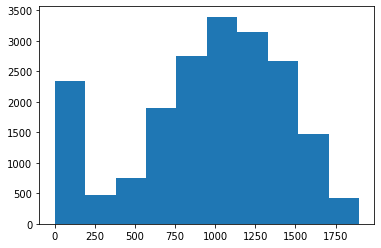

In [705]:
plt.hist(gdf_iso.geometry.to_crs(isr_crs).area.apply(lambda x: np.sqrt(x/np.pi)))

In [707]:
gdf_iso.geometry.to_crs(isr_crs).area.apply(lambda x: np.sqrt(x/np.pi))[gdf_iso.geometry.to_crs(isr_crs).area.apply(lambda x: np.sqrt(x/np.pi))>100].mean()

1057.9478696522249

In [703]:
import numpy as np

In [694]:
gdf_zones_raw_stat = gdf_full_dataset_good[['dbscan_num','geometry','penetration_target','predict_penetration_users']+model_cols].dissolve(by=['dbscan_num'], aggfunc='mean').\
join(gdf_full_dataset_good.groupby(['dbscan_num'])['orders_target','predict_orders','pop_v3'].sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [695]:
gdf_zones_raw_stat.to_file('gdf_zones_raw_stat.geojson', driver='GeoJSON')

In [955]:
greenplum.write(full_dataset, 'snb_geo_lavka.isr_hex_main_stat_with_prediction')